<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [6]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    return self.best_feature_ids

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.8600000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

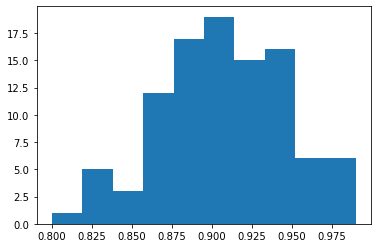

In [5]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

### Explanation:
Very interesting, firstly I didn't buy the *hint* and took some time checking whether there're some logic errors beneath coding and turned out there aren't. Then I try to find the overall logic error, and I have to say that's so counterintuitive. Basically, the model knows something that it shouldn't know beforehand, during the process of Feature Selecting. When applied the feature selection we used information from both the training set and the test sets for the cross-validation, in this case, the correlation values. In fact, when calculating Accuracy in the i-th iteration of cross-validation should be using only the information on the training fold, and nothing should come from the test fold.

I also find good illustration in https://github.com/mottalrd/cross-validation-done-wrong, with decent graphs, so what we did wrong is like the graph below:

<img src="cv_example_wrong.png" width="80%" height="80%">

And it should be like:

<img src="cv_example_right.png" width="80%" height="80%">

In [6]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)
accuracy = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_feature_ids = FeatureSelector(num_features_best).fit(X_train, y_train)
    X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
    X_test_best = X_test[:,best_feature_ids]
    
    model = LinearSVC()
    model.fit(X_train_best, y_train)
    
    pred = model.predict(X_test_best)
    accuracy.append(accuracy_score(y_test, pred))
    
mean_accuracy = np.mean(accuracy)
round(mean_accuracy,2)

0.5

Now it looks reasonable.

## Task 2 (3 points)

Let's come back to Task 3 *(task 1 I guess?)* of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [1]:
import wget
url = "https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv"
wget.download(url)

'train.csv'

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### From previous work we got an accuracy of 0.83

In [34]:
# previous code from Data Handling HW
def feature_selection_and_preprocessing(dataset):
    # <YOUR CODE>
    features = dataset.copy()
    features = features[["Pclass","Sex","Age","SibSp","Parch"]]
    features["Age"] = features["Age"].fillna(features["Age"].median())
    features["Sex"].replace({"female": 0,"male": 1}, inplace=True)
    features[["Age","SibSp","Parch"]] = features[["Age","SibSp","Parch"]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return features


model = KNeighborsClassifier(
    # <YOUR CODE>
    n_neighbors=3
)

# Validation code (do not touch)
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))


Test accuracy: 0.83


#### Use `sklearn.model_selection.GridSearchCV` to find best parameters

In [37]:
parameters = {
        'weights': ['uniform', 'distance'],
        'leaf_size': [i for i in range(20,40)],
        'n_neighbors': [i for i in range(11)],
        'p': [i for i in range(5)]
        }

model4clf = KNeighborsClassifier()
clf = GridSearchCV(model4clf, parameters, scoring='accuracy', n_jobs=-1, verbose=2)

In [38]:
clf.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

Fitting 5 folds for each of 2200 candidates, totalling 11000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4800 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 9328 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 11000 out of 11000 | elapsed:   26.3s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
                         'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [0, 1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [39]:
knn_best = clf.best_estimator_
test_predictions = knn_best.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.85


#### As seen, we got an improvement in Test accuracy, best estimators is shown below:

In [40]:
clf.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=4)